# Implementation Details

1. Creating the eight sets of emotions based on Plutchik's Wheel.
2. Importing the tweets to be analyzed.
3. Applying sentiment analysis to the tweets and arranging the resulting data in a dataframe.

## *The creation of the eight emotion sets of Plutchik's Wheel*

*Using an English-English dictionary containing numerous words with their explanations, the eight emotion sets of Plutchik's Wheel were generated. The primary emotions of Plutchik's Wheel are joy, trust, fear, surprise, sadness, disgust, anger, and anticipation.*

*Initially, dictionaries were formed for each emotion, where words were used as 'keys' and their number as 'values'. The words found within the explanation of each emotion were included in their respective dictionary, along with their numbers. Following that, the dictionaries were expanded by adding the words found within the explanations of each 'key'. The repetition of this process is controllable by the depth of the set function. In the event of encountering duplicate words, the 'value' will be incremented based on their number.*

*Eventually, the dictionaries for each emotion were saved as separate JSON files for future usage.*

In [1]:
# Import the modules required
import pandas as pd
import json
import operator
import requests
import regex as re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from string import digits
pd.options.display.max_colwidth = 280
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading the dictionary that will be used  to create the sets
data = json.load(open(r"thesaurus.json"))

In [3]:
# Set a function taking out related words for a given word and putting them all into a dictionary

def find_related(input_string: str, dictionary: dict, depth: int = 1):
    if input_string not in dictionary:
        return
# I used 'source and target' since we can't make changes in the dictionary in Python while traversing over it
    source = {input_string: 1}
    target = {}

    for i in range(depth):
        for word1 in source:
            if word1 not in dictionary:
                continue

            # Find the related words
            description = dictionary[word1]
        
            for word in description:

                # Build dictionary from list
                if word not in target:
                    target[word] = 1
                else:
                    target[word] += 1

        source.clear()
        source = target.copy()

    return target

In [4]:
# Set a function sorting the emotion dictionaries in descending order, and adjusting their lengths to make them equivalent

def limit_of_set (emotion, depth, limit):
    
    set = find_related(emotion, data, depth)
    print('The length of', emotion, 'dictionary: ', len(set))
    
    # Sort the dictionary in a descending order based on its values.
    order_set = dict( sorted(set.items(), key=operator.itemgetter(1), reverse=True))
    
    # Trim the dictionary at a specific point
    emotion_set = {}
    for key, value in order_set.items():
        if len(emotion_set) > limit:
            break
        emotion_set[key] = value
    print('The length of', emotion, 'dictionary after cutting: ', len(emotion_set))
    
    # Equalize the dictionary values after cutting
    emotion_set = dict.fromkeys(emotion_set, 1)
        
    return emotion_set

***Call the function for all emotions***

In [5]:
joy = limit_of_set('joy', 3, 100)
# Store the dictionary in a json file
with open('sets\\joy.json', 'w') as fp:
    json.dump(joy, fp)

trust = limit_of_set('trust', 3, 100)
with open('sets\\trust.json', 'w') as fp:
    json.dump(trust, fp)

fear = limit_of_set('fear', 4, 100)
with open('sets\\fear.json', 'w') as fp:
    json.dump(fear, fp)

surprise = limit_of_set('surprise', 4, 100)
with open('sets\\surprise.json', 'w') as fp:
    json.dump(surprise, fp)

sadness = limit_of_set('sadness', 3, 100)
with open('sets\\sadness.json', 'w') as fp:
    json.dump(sadness, fp)

disgust = limit_of_set('disgust', 4, 100)
with open('sets\\disgust.json', 'w') as fp:
    json.dump(disgust, fp)

anger = limit_of_set('anger', 3, 100)
with open('sets\\anger.json', 'w') as fp:
    json.dump(anger, fp)

anticipation = limit_of_set('anticipation', 4, 100)
with open('sets\\anticipation.json', 'w') as fp:
    json.dump(anticipation, fp)

The length of joy dictionary:  129
The length of joy dictionary after cutting:  101
The length of trust dictionary:  253
The length of trust dictionary after cutting:  101
The length of fear dictionary:  157
The length of fear dictionary after cutting:  101
The length of surprise dictionary:  164
The length of surprise dictionary after cutting:  101
The length of sadness dictionary:  127
The length of sadness dictionary after cutting:  101
The length of disgust dictionary:  206
The length of disgust dictionary after cutting:  101
The length of anger dictionary:  169
The length of anger dictionary after cutting:  101
The length of anticipation dictionary:  101
The length of anticipation dictionary after cutting:  101


In [6]:
# Print some keys of Joy dictionary.
dict(list(joy.items())[:10])

{'transport': 1,
 'ecstasy': 1,
 'rapture': 1,
 'delight': 1,
 'enjoyment': 1,
 'joy': 1,
 'pleasure': 1,
 'happiness': 1,
 'bliss': 1,
 'gladness': 1}

## *The application of sentiment analysis*

***Set a class applying Sentiment Analysis to Tweets by detecting intersections between each Tweet and emotion dictionaries***

In [7]:
class Feeling:
    # Import the dictionaries into the class.
    joy_dic = json.load(open(f"sets\\joy.json"))
    trust_dic = json.load(open(f"sets\\trust.json"))
    fear_dic = json.load(open(f"sets\\fear.json"))
    surprise_dic = json.load(open(f"sets\\surprise.json"))
    sadness_dic = json.load(open(f"sets\\sadness.json"))
    disgust_dic = json.load(open(f"sets\\disgust.json"))
    anger_dic = json.load(open(f"sets\\anger.json"))
    anticipation_dic = json.load(open(f"sets\\anticipation.json"))
    
    def __init__(self, tweet):
        # Assign an initial value to each emotion in each tweet.
        self.joy = 0
        self.trust = 0
        self.fear = 0
        self.surprise = 0
        self.sadness = 0
        self.disgust = 0
        self.anger = 0
        self.anticipation = 0
        self.tot = 0

        self.words = []
        self.split(tweet)
        self.find_frequency()

    def split(self, tweet):
        # Clean the tweets
        res = ''.join([i for i in tweet if not i.isdigit()])
        self.words = re.sub(r'[^\w\s]', '', res.lower()).split()
        for word in self.words:
            if word in stopwords.words('english'):
                self.words.remove(word)
                continue

    def find_frequency(self):
        # Compute the intersections between every tweet and each set of emotion sets.
        for word in self.words:
            self.joy += Feeling.joy_dic.get(word, 0)
            self.trust += Feeling.trust_dic.get(word, 0)
            self.fear += Feeling.fear_dic.get(word, 0)
            self.surprise += Feeling.surprise_dic.get(word, 0)
            self.sadness += Feeling.sadness_dic.get(word, 0)
            self.disgust += Feeling.disgust_dic.get(word, 0)
            self.anger += Feeling.anger_dic.get(word, 0)
            self.anticipation += Feeling.anticipation_dic.get(word, 0)
            self.tot = self.joy+self.trust+self.fear+self.surprise+self.sadness+self.disgust+self.anger+self.anticipation
            
        # Normalize the outcomes
        try:
            self.joy /= self.tot
            self.trust /= self.tot
            self.fear /= self.tot
            self.surprise /= self.tot
            self.sadness /= self.tot
            self.disgust /= self.tot
            self.anger /= self.tot
            self.anticipation /= self.tot
        except:
            pass

## *The importing of tweets to be analyzed*

***Now, import 30000 Tweets related to World Cup 2022 Using Snscrape Libray***

In [8]:
import snscrape.modules.twitter as sntwitter

# Creating list to append tweet data to
tweets_list = []

query = 'world cup 2022 lang:en since:2022-11-20 until:2022-12-20'
limit = 30000

# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
    if i > limit:
        break
    tweets_list.append([tweet.username, tweet.date, tweet.content])
    
# Creating a dataframe to load the list
tweets_df = pd.DataFrame(tweets_list, columns=["User", "Date", "Tweet"])
tweets_df.to_csv('world_cup.csv', index=False)

Unavailable user in card on tweet 1604971095655841798
Unavailable user in card on tweet 1604971095655841798
User 26734856 not found in user refs in card on tweet 1604971095655841798
User 26734856 not found in user refs in card on tweet 1604971095655841798
Unavailable user in card on tweet 1604940393753284608
User 1041604336160137216 not found in user refs in card on tweet 1604940393753284608
Unavailable user in card on tweet 1604928056162152448
Unavailable user in card on tweet 1604928056162152448
User 363577315 not found in user refs in card on tweet 1604928056162152448
User 363577315 not found in user refs in card on tweet 1604928056162152448
Unavailable user in card on tweet 1604923780152692736
User 1041604336160137216 not found in user refs in card on tweet 1604923780152692736
Unavailable user in card on tweet 1604910190528266250
User 1041604336160137216 not found in user refs in card on tweet 1604910190528266250
Unavailable user in card on tweet 1604884301941727237
User 8388246242

Unavailable user in card on tweet 1604657275469287424
User 1041604336160137216 not found in user refs in card on tweet 1604657275469287424
Unavailable user in card on tweet 1604656340860813312
Unavailable user in card on tweet 1604656340860813312
User 756510393900666880 not found in user refs in card on tweet 1604656340860813312
User 756510393900666880 not found in user refs in card on tweet 1604656340860813312
Unavailable user in card on tweet 1604653725917888512
User 2226005232 not found in user refs in card on tweet 1604653725917888512
Unavailable user in card on tweet 1604633909769433088
Unavailable user in card on tweet 1604633909769433088
User 1630083736837521409 not found in user refs in card on tweet 1604633909769433088
User 1630083736837521409 not found in user refs in card on tweet 1604633909769433088
Unavailable user in card on tweet 1604619527349829632
User 1041604336160137216 not found in user refs in card on tweet 1604619527349829632
Unavailable user in card on tweet 1604

In [9]:
tweets_df = pd.read_csv('world_cup.csv')
tweets_df

,User,Date,Tweet
0,MessiGoatesque,2022-12-19 23:59:53+00:00,"MessiStats_: 03.12.2022\nWorld Cup Round of 16\nArgentina vs Australia 2-1\n\nMessi marked his 1,000th senior career game with his first goal in the knockout stage of a World Cup in a victory over Australia.\n\nIt was also Messi's 100th game as a starting capt… https://t.co/h..."
1,MessiGoatesque,2022-12-19 23:59:52+00:00,"MessiStats_: 30.11.2022\nWorld Cup group stage\nPoland vs Argentina 0-2\n\nMessi missed a penalty on his record-breaking 22nd World Cup match, one more than the late Diego Maradona managed for La Albiceleste.\n\nIt is the only match of the 2022 World Cup witho… https://t.co/I..."
2,MessiGoatesque,2022-12-19 23:59:51+00:00,"MessiStats_: Against Mexico, Messi lifted his goal tally for Argentina in 2022 to 13, more than in any other calendar year. His previous record was 12 goals from 2021.\n\nHe also registered his first assist of the 2022 World Cup by setting up Enzo Fernande… https://t.co/YC8Xx..."
3,MessiGoatesque,2022-12-19 23:59:50+00:00,"MessiStats_: 26.11.2022\nWorld Cup, group stage\nArgentina vs Mexico 2-0\n\nMessi produced a moment of trademark magic to help keep Argentina's World Cup hopes alive in a much needed victory.\n\nIt was an eighth World Cup goal for Messi, who played his 21st Wo… https://t.co/u..."
4,MessiGoatesque,2022-12-19 23:59:49+00:00,"MessiStats_: 26.11.2022\nWorld Cup, group stage\nArgentina vs Mexico 2-0\n\nMessi produced a moment of trademark magic to help keep Argentina's World Cup hopes alive in a much needed victory.\n\nIt was an eighth World Cup goal for Messi, who played his 21st Wo… https://t.co/L..."
...,...,...,...
29996,chickchick42,2022-12-18 17:58:35+00:00,2022 World Cup. \nSeriously Great to watch ❤️⚽
29997,Sakhuu3,2022-12-18 17:58:35+00:00,Argentina has won the 2022 FIFA World Cup 🏆 \n\nTheir prize money: $42 million — the most in tournament history.\n\n#Argentina #France\n #Mbappe \n#Messi𓃵\n#ArgentinaVsFrance #FIFAWorldCup2022\n#FIFAWorldCup \n#FIFAWorldCupQatar2022 https://t.co/OhXK3ulKcb
29998,shfiqnasir,2022-12-18 17:58:35+00:00,2022 FIFA WORLD CUP CHAMPION: ARGENTINA 🇦🇷
29999,Jacki3_Daytona_,2022-12-18 17:58:34+00:00,"Congratulations to Argentina, winners of the 2022 World Cup! 🏆⚽\n\n#WorldCup #WorldCup2022 #WorldCupFinal #WorldCupMemes #Messi #GOAT\n#WhatWeDoInTheShadows #WhatWeDoInTheShadowsFX #WWDITS #WWDITSMemes #MattBerry #KayvanNovak #Guillermo #NandorTheRelentless #Nadja #Laszlo htt..."


### *Run the class and arrange the results in a DataFrame.*

In [10]:
# Create an empty dataframe with column names
df = pd.DataFrame(columns = ['Tweet', 'Joy', 'Trust', 'Fear', 'Surprise',
                             'Sadness', 'Disgust', 'Anger', 'Anticipation'])

# Fill the dataframe with the result of each tweet row by row
for twt in tweets_df['Tweet']:
    tweet = Feeling(twt)
    df.loc[len(df)] = [twt, tweet.joy, tweet.trust, tweet.fear, tweet.surprise,
                       tweet.sadness, tweet.disgust, tweet.anger, tweet.anticipation]

# Drop the rows from the dataframe that contain only zeros 
df = df.set_index('Tweet')
df = df[(df.select_dtypes(include=['number']) != 0).any(1)]

# Add a row containing the mean of each emotion for all Tweets
df.loc['Mean'] = df.mean()
df

,Joy,Trust,Fear,Surprise,Sadness,Disgust,Anger,Anticipation
Tweet,,,,,,,,
The 2022 World Cup has come to an end!\n\nWe had a blast hosting our Trivia event! Thank you all for participating and congrats to our winners!! 🏆 https://t.co/sm6wfddA43,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"@Donmagik1 @touchlinefracas My point is that Martinez can celebrate however he wants cuz Mbappe lost the 2022 World Cup , Un Momentoooo se silenciooo Shhhhhhhh Para Mbappe que esta muertooooo ea ea ea ea ea lol",1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"For More Latest News Click Here: 👇👇👇\nhttps://t.co/RuEJJTaZLR\n\n2022 FIFA World Cup: Best late-game goals | 2022 FIFA World Cup\n\nCheck out these game-changing goals scored in the 80th minute and beyond from the 2022 FIFA World Cup. Includes Lionel Messi, Kylian Mbappé and more!",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
Check out this NFT (Kandinsky Immortal Style) for auction in Open Sea of the Collection from the Qatar Stadium that hosted the 2022 World Cup final with the victory of Argentina.\n\nIt can be yours for just 0.0002 ETH. Are you going to let it go?\nhttps://t.co/Xh5kLpjzPb by @opensea,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
"to western media we are living in 2022 so no one believes your lies and hypocrisy,stop covering your shame by propaganda about the world cup if a photo of Messi wearing Arabic besht make you feel sad then go watch your crimes in MiddleEast hopefully it makes you happy @BBCNews https://t.co/WglzUuXnFB",0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
Much props to the defending champs France for showing the world why they were the champs to begin with. Mbappe did his thing and than some. That dude is the truth!\n\nCongrats to Messi and Argentina finally winning the World Cup 2022. Yall deserve it. #FIFAWorldCup,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Congratulations to Argentina 🇦🇷 for winning the 2022 World Cup. Good job to France 🇫🇷 for playing with such enthusiasm that they can go this far. What a game. What a final... Messi win first world cup #FifaWorldCup 2022,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
@vanguardngrnews Congratulations Argentina.\nWell deserved.\nWinner World cup 2022.\nGreat win for Messi.\nTruly the best player in the world at this time.\nComing towards the end of his career.,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<AxesSubplot:title={'center':'The emotional distribution surrounding the World Cup 2022 based on 30000 tweets'}>

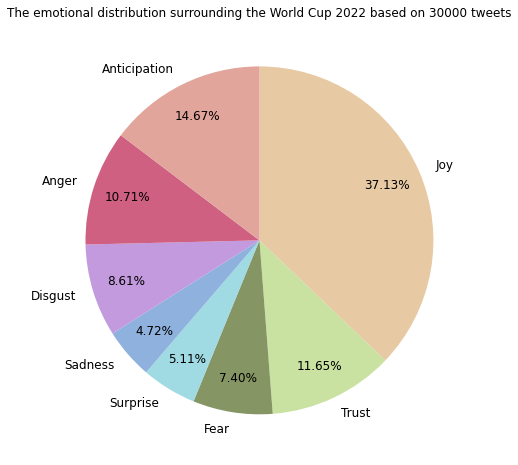

In [11]:
# Visualize the results in a pie chart
colors = ['#E7CAA3','#C9E1A1','#869564','#A0DAE2','#8FB1DD','#C39ADD','#CF6081','#E2A59B']
df.iloc[len(df)-1].plot.pie(figsize=(8, 8),colors=colors, fontsize=12, autopct='%1.2f%%',
                                 startangle=90, counterclock=False, pctdistance=0.8, label="",
                                 title = 'The emotional distribution surrounding the World Cup 2022 based on 30000 tweets')

### *Let's test the model on another topic, COVID-19 pandemic for example*

In [12]:
tweets_list1 = []

query = 'covid lang:en since:2019-11-17 until:2020-02-17'
limit = 30000

for i,tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
    if i > limit:
        break
    tweets_list1.append([tweet.username, tweet.date, tweet.content])
    
tweets_df1 = pd.DataFrame(tweets_list1, columns=["User", "Date", "Tweet"])
tweets_df1.to_csv('covid.csv', index=False)

Unavailable user in card on tweet 1229189826345345025
User 218852667 not found in user refs in card on tweet 1229189826345345025
Unavailable user in card on tweet 1229049768195829760
Unavailable user in card on tweet 1229049768195829760
User 15843059 not found in user refs in card on tweet 1229049768195829760
User 15843059 not found in user refs in card on tweet 1229049768195829760
Unavailable user in card on tweet 1228895048525402112
Unavailable user in card on tweet 1228895048525402112
User 1630083736837521409 not found in user refs in card on tweet 1228895048525402112
User 1630083736837521409 not found in user refs in card on tweet 1228895048525402112
Unavailable user in card on tweet 1228872639806087168
User 218852667 not found in user refs in card on tweet 1228872639806087168
Unavailable user in card on tweet 1228707310387826691
Unavailable user in card on tweet 1228707310387826691
User 1637252214 not found in user refs in card on tweet 1228707310387826691
User 1637252214 not foun

In [14]:
tweets_df1 = pd.read_csv('covid.csv')
tweets_df1

,User,Date,Tweet
0,reinterpreterdj,2020-02-16 23:59:42+00:00,Coronavirus (COVID-19): latest information and advice @GOVUK https://t.co/TfhL2Ut4EA
1,nopittie,2020-02-16 23:59:40+00:00,"@howroute I am not buying it. Besides, how many of the people lapping up the conspiracy theories about COVID-19 refuse to get the flu shot knowing it kills more than this? If a vaccination was made for COVID-19, would they get it? Doubtful 😒"
2,SuperCycleBear,2020-02-16 23:59:36+00:00,@ChrisWeston_PS WTF? Before any impact of covid 19? Hard to think this is business as usual anytime soon
3,PubTrend,2020-02-16 23:59:31+00:00,Trending on PubMed: Case of the Index Patient Who Caused Tertiary Transmission of COVID-19 Infection in Korea: the Application of Lopinavir/Ritonavir for the Treatment of COVID-19 Infected Pneumonia Monitored by Quantitative RT-PCR. https://t.co/x5OSRW2EdG
4,Conga1,2020-02-16 23:59:23+00:00,"As cruise ship COVID-19 numbers climb, nations evacuate passengers https://t.co/RmbC7ME90s via CIDRAP Center for Infectious Disease Research and Policy, Feb. 16, 2020"
...,...,...,...
29996,amandaleegp,2020-02-12 00:29:58+00:00,COVID-19: WHO renames deadly coronavirus @AJENews https://t.co/lWUxsOfZNS
29997,DonaldJTrumpNY1,2020-02-12 00:29:51+00:00,Pelosi Impeachment #TrumpsGuilty Bolton McConnell Schiff #GOPBETRAYEDAMERICA Romney Vindmans #TrumpBudget #NightoftheLongKnives #OrangeFace Giuliani #BloombergIsRacist #NewHampshirePrimary COVID-19 Coronavirus William Barr Prosecutors Trump and Barr Department of Justice The ...
29998,ArthurVallejomd,2020-02-12 00:29:50+00:00,"@business Both the total number of cases and the number of deaths are for patients who were confirmed to be infected in large hospitals by rRT-PCR, a test that remains in very short supply throughout China. Real case numbers and real deaths from COVID-2019 are much, much hig..."
29999,mlq3,2020-02-12 00:29:49+00:00,So now it's called COVID-19. Check out the real-time updated map. https://t.co/mp50y1lgmG https://t.co/bqLmFYyRSa


In [15]:
df1 = pd.DataFrame(columns = ['Tweet', 'Joy', 'Trust', 'Fear', 'Surprise',
                             'Sadness', 'Disgust', 'Anger', 'Anticipation'])

for twt in tweets_df1['Tweet']:
    tweet = Feeling(twt)
    df1.loc[len(df1)] = [twt, tweet.joy, tweet.trust, tweet.fear, tweet.surprise,
                       tweet.sadness, tweet.disgust, tweet.anger, tweet.anticipation]

df1 = df1.set_index('Tweet')
df1 = df1[(df1.select_dtypes(include=['number']) != 0).any(1)]

df1.loc['Mean'] = df1.mean()
df1

,Joy,Trust,Fear,Surprise,Sadness,Disgust,Anger,Anticipation
Tweet,,,,,,,,
@ChrisWeston_PS WTF? Before any impact of covid 19? Hard to think this is business as usual anytime soon,0.000000,0.500000,0.000000,0.000000,0.00000,0.000000,0.000000,0.500000
"As cruise ship COVID-19 numbers climb, nations evacuate passengers https://t.co/RmbC7ME90s via CIDRAP Center for Infectious Disease Research and Policy, Feb. 16, 2020",0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000
National medical team to confront COVID-19 holds meeting https://t.co/0HcH8IU5nY,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000
@itnEditor Statement addresses the #FDA's role in overseeing #medical products and equipment as part its mission to protect and promote public health: https://t.co/HA3KweEFAR\n#coronoavirusoutbreak #novelcoronavirus2019 #COVID_19,0.000000,0.500000,0.000000,0.000000,0.00000,0.000000,0.000000,0.500000
"#COVID_19 will take its course when it landed at any land either you let it pass and accept it fast harm or you resist, when you resist is only letting the Virus 🦠 to stay &amp; demolish your life and your systems ! https://t.co/BC9VhzLEvE",0.000000,0.000000,0.000000,0.000000,0.50000,0.000000,0.500000,0.000000
...,...,...,...,...,...,...,...,...
Coronavirus Has a Name: The Deadly Disease Is Covid-19 https://t.co/4CttFN7jkR,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000
New #Coronavirus Disease Officially Named COVID-19 By @WHO https://t.co/oncaRYtXgC\nvia @NPRGoatsandSoda https://t.co/BPkcyIxbvy,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000
"@business Both the total number of cases and the number of deaths are for patients who were confirmed to be infected in large hospitals by rRT-PCR, a test that remains in very short supply throughout China. Real case numbers and real deaths from COVID-2019 are much, much higher.",0.000000,0.500000,0.000000,0.000000,0.00000,0.000000,0.000000,0.500000


<AxesSubplot:title={'center':'The emotional distribution surrounding COVID-19 pandemic based on 30000 tweets'}>

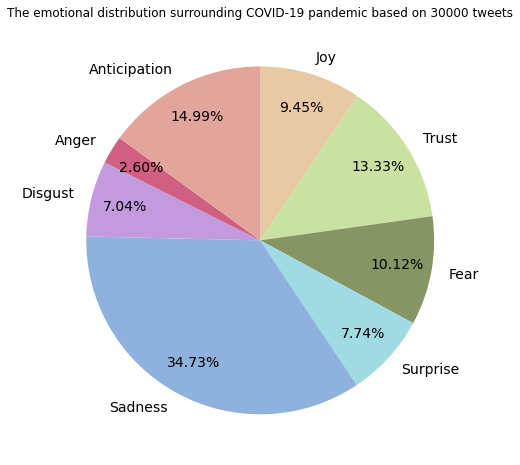

In [16]:
# Visualize the results in a pie chart
df1.iloc[len(df1)-1].plot.pie(figsize=(8, 8),colors=colors, fontsize=14, autopct='%1.2f%%',
                                   startangle=90, counterclock=False, pctdistance=0.8, label="",
                                   title = 'The emotional distribution surrounding COVID-19 pandemic based on 30000 tweets')